In [1]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression

In [2]:
data = pd.read_csv("../Dataset/Jin2017/data.csv")

In [3]:
data

,miRNA,CON-1,CON-2,CON-3,CON-4,CON-5,CON-6,CON-7,CON-8,CON-9,...,SCC-1,SCC-2,SCC-3,SCC-4,SCC-5,SCC-6,SCC-7,SCC-8,SCC-9,SCC-10
0,hsa-let-7a-2-3p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,hsa-let-7a-3p,6.515507,20.902514,146.033115,37.015298,38.090595,61.473678,43.168806,327.037377,78.165009,...,493.047263,57.930362,NaN,181.093807,50.519084,NaN,216.702332,419.435135,NaN,NaN
2,hsa-let-7a-5p,43745.113370,36244.959390,27806.095840,131369.054900,59179.724490,68309.209180,90409.706310,22878.016520,25276.946710,...,140433.727500,56908.957860,11081.226470,42919.232160,33363.644780,31264.367820,153154.373300,95433.252970,28009.800650,77704.276050
3,hsa-let-7b-3p,NaN,29.376506,18.080290,49.353731,47.885319,20.491226,45.621579,119.719040,NaN,...,15.407727,7.622416,NaN,NaN,4.209924,NaN,NaN,90.158954,NaN,2.572989
4,hsa-let-7b-5p,NaN,NaN,NaN,NaN,6.529816,0.853801,14.226084,NaN,NaN,...,1779.592466,6640.648820,2187.556034,20825.787760,2117.591587,37547.892720,5444.646098,1177.946336,7406.169952,25.729893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,hsa-miR-98-5p,794.891843,2339.386777,720.430033,6058.170422,2076.481561,2440.163486,4308.541194,129.938958,21.562761,...,1394.399291,97.566925,NaN,362.187613,269.435112,459.770115,2464.989029,1993.296878,111.370977,18.010925
952,hsa-miR-99a-3p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
953,hsa-miR-99a-5p,45.608548,142.363069,267.031981,31.727398,204.600909,197.228049,257.050619,998.631991,1126.654268,...,92.446362,105.189341,NaN,NaN,54.729007,613.026820,27.087792,35.279591,NaN,NaN
954,hsa-miR-99b-3p,13.031014,10.168791,130.734408,NaN,1.088303,25.614032,37.282151,8.759930,21.562761,...,NaN,NaN,NaN,181.093807,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
table = data.iloc[:, 1:].transpose()
mirnas = data.iloc[:, 0]

In [5]:
controls = np.array(["CON" in k for k in data.columns[1:]])
sick = 1 - controls

In [6]:
controls

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [7]:
table.head()

,0,1,2,3,4,5,6,7,8,9,...,946,947,948,949,950,951,952,953,954,955
CON-1,NaN,6.515507,43745.11337,NaN,NaN,NaN,4626.009904,78.186083,4684.649466,NaN,...,NaN,286.682304,299.713318,32.577535,13.031014,794.891843,NaN,45.608548,13.031014,3570.497785
CON-2,NaN,20.902514,36244.95939,29.376506,NaN,NaN,3909.899996,329.920763,11702.583210,4.519463,...,NaN,16.947984,3.954530,NaN,2.259731,2339.386777,NaN,142.363069,10.168791,11889.575970
CON-3,NaN,146.033115,27806.09584,18.080290,NaN,NaN,2008.303026,94.573827,3182.131110,26.425040,...,NaN,891.497396,1546.560225,8.344749,5.563166,720.430033,NaN,267.031981,130.734408,14282.038620
CON-4,NaN,37.015298,131369.05490,49.353731,NaN,NaN,4877.206156,505.875738,51985.341940,8.813166,...,NaN,NaN,NaN,NaN,3.525266,6058.170422,NaN,31.727398,NaN,3371.917375
CON-5,NaN,38.090595,59179.72449,47.885319,6.529816,2.176605,107596.135200,452.733925,34343.568460,3.264908,...,NaN,1.088303,1.088303,NaN,8.706422,2076.481561,NaN,204.600909,1.088303,5945.397677


In [8]:
mask = table.isna().sum() < 30
table = table.loc[:, mask]
mirnas = mirnas[mask]

In [9]:
table = table.fillna(table.min().min())

In [10]:
table.head()

,1,2,3,4,6,7,8,9,10,11,...,942,945,947,948,949,950,951,953,954,955
CON-1,6.515507,43745.11337,0.490555,0.490555,4626.009904,78.186083,4684.649466,0.490555,7010.685431,0.490555,...,156.372166,1733.124837,286.682304,299.713318,32.577535,13.031014,794.891843,45.608548,13.031014,3570.497785
CON-2,20.902514,36244.95939,29.376506,0.490555,3909.899996,329.920763,11702.583210,4.519463,5962.300904,27.116775,...,6.214261,513.523927,16.947984,3.954530,0.490555,2.259731,2339.386777,142.363069,10.168791,11889.575970
CON-3,146.033115,27806.09584,18.080290,0.490555,2008.303026,94.573827,3182.131110,26.425040,4657.760965,11.126333,...,524.328421,1168.264918,891.497396,1546.560225,8.344749,5.563166,720.430033,267.031981,130.734408,14282.038620
CON-4,37.015298,131369.05490,49.353731,0.490555,4877.206156,505.875738,51985.341940,8.813166,18026.450070,28.202132,...,5.287900,537.603136,0.490555,0.490555,0.490555,3.525266,6058.170422,31.727398,0.490555,3371.917375
CON-5,38.090595,59179.72449,47.885319,6.529816,107596.135200,452.733925,34343.568460,3.264908,9998.236950,47.885319,...,0.490555,0.490555,1.088303,1.088303,0.490555,8.706422,2076.481561,204.600909,1.088303,5945.397677


### T-test

In [11]:
X = table

In [12]:
X

,1,2,3,4,6,7,8,9,10,11,...,942,945,947,948,949,950,951,953,954,955
CON-1,6.515507,43745.113370,0.490555,0.490555,4626.009904,78.186083,4684.649466,0.490555,7010.685431,0.490555,...,156.372166,1733.124837,286.682304,299.713318,32.577535,13.031014,794.891843,45.608548,13.031014,3570.497785
CON-2,20.902514,36244.959390,29.376506,0.490555,3909.899996,329.920763,11702.583210,4.519463,5962.300904,27.116775,...,6.214261,513.523927,16.947984,3.954530,0.490555,2.259731,2339.386777,142.363069,10.168791,11889.575970
CON-3,146.033115,27806.095840,18.080290,0.490555,2008.303026,94.573827,3182.131110,26.425040,4657.760965,11.126333,...,524.328421,1168.264918,891.497396,1546.560225,8.344749,5.563166,720.430033,267.031981,130.734408,14282.038620
CON-4,37.015298,131369.054900,49.353731,0.490555,4877.206156,505.875738,51985.341940,8.813166,18026.450070,28.202132,...,5.287900,537.603136,0.490555,0.490555,0.490555,3.525266,6058.170422,31.727398,0.490555,3371.917375
CON-5,38.090595,59179.724490,47.885319,6.529816,107596.135200,452.733925,34343.568460,3.264908,9998.236950,47.885319,...,0.490555,0.490555,1.088303,1.088303,0.490555,8.706422,2076.481561,204.600909,1.088303,5945.397677
CON-6,61.473678,68309.209180,20.491226,0.853801,95951.019140,220.280679,35058.779940,7.684210,11871.250210,24.760231,...,0.490555,0.853801,0.490555,12.807016,0.490555,15.368419,2440.163486,197.228049,25.614032,3934.315375
CON-7,43.168806,90409.706310,45.621579,14.226084,107926.921100,458.668566,38310.843860,7.358319,15407.339380,37.772705,...,0.490555,0.490555,0.490555,1.962218,0.490555,6.867765,4308.541194,257.050619,37.282151,2284.022293
CON-8,327.037377,22878.016520,119.719040,0.490555,2011.863865,1534.447694,7002.103843,0.490555,3309.793455,0.490555,...,0.490555,0.490555,0.490555,37.959696,0.490555,0.490555,129.938958,998.631991,8.759930,534.355714
CON-9,78.165009,25276.946710,0.490555,0.490555,1609.121048,1013.449772,5703.350314,0.490555,4266.731355,8.086035,...,0.490555,0.490555,0.490555,0.490555,0.490555,0.490555,21.562761,1126.654268,21.562761,404.301771
CON-10,11.817281,55403.353350,0.490555,0.490555,4762.364323,55.147312,7578.816342,0.490555,6343.910457,7.878187,...,3.939094,0.490555,0.490555,1.969547,0.490555,0.490555,86.660062,401.787561,23.634562,35.451844


In [13]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [14]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [15]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [16]:
mirnas.iloc[lowest], pvalues

(318     hsa-miR-30a-3p
 373       hsa-miR-320b
 163     hsa-miR-15b-3p
 56     hsa-miR-1249-3p
 372       hsa-miR-320a
 Name: miRNA, dtype: object,
 array([2.27964967e-09, 1.88370762e-07, 1.89201394e-06, 8.54201170e-06,
        2.00142553e-05]))

### F-test

In [17]:
t3 = table

In [18]:
f, p = f_classif(t3, sick)

In [19]:
np.mean(p)

0.22912412441623953

### ANOVA

In [20]:
t3

,1,2,3,4,6,7,8,9,10,11,...,942,945,947,948,949,950,951,953,954,955
CON-1,6.515507,43745.113370,0.490555,0.490555,4626.009904,78.186083,4684.649466,0.490555,7010.685431,0.490555,...,156.372166,1733.124837,286.682304,299.713318,32.577535,13.031014,794.891843,45.608548,13.031014,3570.497785
CON-2,20.902514,36244.959390,29.376506,0.490555,3909.899996,329.920763,11702.583210,4.519463,5962.300904,27.116775,...,6.214261,513.523927,16.947984,3.954530,0.490555,2.259731,2339.386777,142.363069,10.168791,11889.575970
CON-3,146.033115,27806.095840,18.080290,0.490555,2008.303026,94.573827,3182.131110,26.425040,4657.760965,11.126333,...,524.328421,1168.264918,891.497396,1546.560225,8.344749,5.563166,720.430033,267.031981,130.734408,14282.038620
CON-4,37.015298,131369.054900,49.353731,0.490555,4877.206156,505.875738,51985.341940,8.813166,18026.450070,28.202132,...,5.287900,537.603136,0.490555,0.490555,0.490555,3.525266,6058.170422,31.727398,0.490555,3371.917375
CON-5,38.090595,59179.724490,47.885319,6.529816,107596.135200,452.733925,34343.568460,3.264908,9998.236950,47.885319,...,0.490555,0.490555,1.088303,1.088303,0.490555,8.706422,2076.481561,204.600909,1.088303,5945.397677
CON-6,61.473678,68309.209180,20.491226,0.853801,95951.019140,220.280679,35058.779940,7.684210,11871.250210,24.760231,...,0.490555,0.853801,0.490555,12.807016,0.490555,15.368419,2440.163486,197.228049,25.614032,3934.315375
CON-7,43.168806,90409.706310,45.621579,14.226084,107926.921100,458.668566,38310.843860,7.358319,15407.339380,37.772705,...,0.490555,0.490555,0.490555,1.962218,0.490555,6.867765,4308.541194,257.050619,37.282151,2284.022293
CON-8,327.037377,22878.016520,119.719040,0.490555,2011.863865,1534.447694,7002.103843,0.490555,3309.793455,0.490555,...,0.490555,0.490555,0.490555,37.959696,0.490555,0.490555,129.938958,998.631991,8.759930,534.355714
CON-9,78.165009,25276.946710,0.490555,0.490555,1609.121048,1013.449772,5703.350314,0.490555,4266.731355,8.086035,...,0.490555,0.490555,0.490555,0.490555,0.490555,0.490555,21.562761,1126.654268,21.562761,404.301771
CON-10,11.817281,55403.353350,0.490555,0.490555,4762.364323,55.147312,7578.816342,0.490555,6343.910457,7.878187,...,3.939094,0.490555,0.490555,1.969547,0.490555,0.490555,86.660062,401.787561,23.634562,35.451844


In [21]:
X = np.array(sick).reshape(-1, 1)

In [22]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [23]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.10239496975979728

### Mean-variance-plot

In [24]:
np.mean(table)

1        194.199142
2      46164.583735
3         61.634862
4      61166.290815
6      11001.905801
           ...     
950        9.838902
951      822.832629
953      371.834176
954       28.622552
955     1343.225246
Length: 527, dtype: float64

In [25]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [26]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

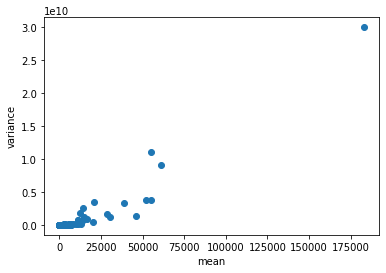

In [27]:
mean_variance_plot(table)

### Log transformation

In [28]:
log_table = table #np.log2(table)

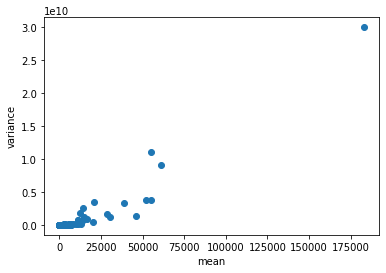

In [29]:
mean_variance_plot(log_table)

In [30]:
log_table.isna().sum().sum()

0

In [31]:
norm_log_table = log_table #- np.mean(log_table)

In [32]:
#norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

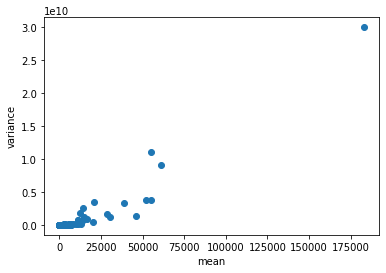

In [33]:
mean_variance_plot(norm_log_table)

### PCA

In [34]:
pca = decomposition.PCA(n_components=10)

In [35]:
norm_log_table.isna().sum().sum()

0

In [36]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [37]:
pca.explained_variance_ratio_

array([0.40670433, 0.21914396, 0.12617961, 0.08803523, 0.03078068,
       0.02717239, 0.02239606, 0.01925201, 0.01750293, 0.01096483])

In [38]:
components = pca.transform(norm_log_table)

In [39]:
components.shape

(38, 10)

In [40]:
sum(controls)

12

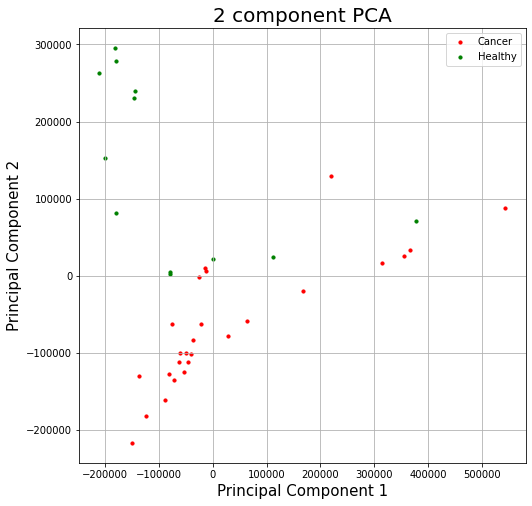

In [41]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [42]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

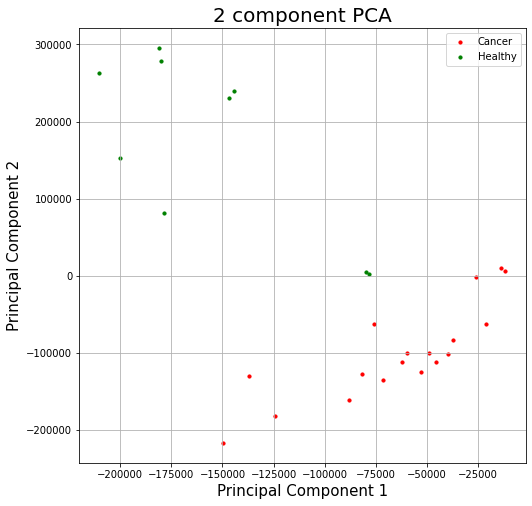

In [43]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [44]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [45]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


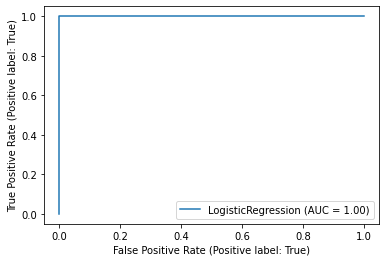

In [46]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [47]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[18:24:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


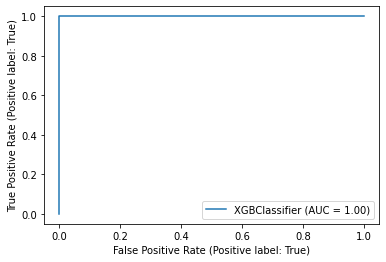

In [48]:
plot_roc_curve(model, X_test, y_test)

### Export data

In [49]:
mirnas[:10]

1       hsa-let-7a-3p
2       hsa-let-7a-5p
3       hsa-let-7b-3p
4       hsa-let-7b-5p
6       hsa-let-7c-5p
7       hsa-let-7d-3p
8       hsa-let-7d-5p
9       hsa-let-7e-3p
10      hsa-let-7e-5p
11    hsa-let-7f-1-3p
Name: miRNA, dtype: object

In [50]:
from Scripts import converters

In [51]:
sequences = converters.canonical_to_seq(mirnas)

In [52]:
norm_log_table.columns = sequences
norm_log_table["cancer"] = sick
norm_log_table.head()

,CUAUACAAUCUACUGUCUUUC,UGAGGUAGUAGGUUGUAUAGUU,CUAUACAACCUACUGCCUUCCC,UGAGGUAGUAGGUUGUGUGGUU,UGAGGUAGUAGGUUGUAUGGUU,CUAUACGACCUGCUGCCUUUCU,AGAGGUAGUAGGUUGCAUAGUU,CUAUACGGCCUCCUAGCUUUCC,UGAGGUAGGAGGUUGUAUAGUU,CUAUACAAUCUAUUGCCUUCCC,...,UCUUCUCUGUUUUGGCCAUGUG,UUCAACGGGUAUUUAUUGAGCA,UCUUUGGUUAUCUAGCUGUAUGA,UUUGGCACUAGCACAUUUUUGCU,CUAUACAACUUACUACUUUCCC,UGAGGUAGUAAGUUGUAUUGUU,AACCCGUAGAUCCGAUCUUGUG,CAAGCUCGUGUCUGUGGGUCCG,CACCCGUAGAACCGACCUUGCG,cancer
CON-1,6.515507,43745.11337,0.490555,0.490555,4626.009904,78.186083,4684.649466,0.490555,7010.685431,0.490555,...,1733.124837,286.682304,299.713318,32.577535,13.031014,794.891843,45.608548,13.031014,3570.497785,0
CON-2,20.902514,36244.95939,29.376506,0.490555,3909.899996,329.920763,11702.583210,4.519463,5962.300904,27.116775,...,513.523927,16.947984,3.954530,0.490555,2.259731,2339.386777,142.363069,10.168791,11889.575970,0
CON-3,146.033115,27806.09584,18.080290,0.490555,2008.303026,94.573827,3182.131110,26.425040,4657.760965,11.126333,...,1168.264918,891.497396,1546.560225,8.344749,5.563166,720.430033,267.031981,130.734408,14282.038620,0
CON-4,37.015298,131369.05490,49.353731,0.490555,4877.206156,505.875738,51985.341940,8.813166,18026.450070,28.202132,...,537.603136,0.490555,0.490555,0.490555,3.525266,6058.170422,31.727398,0.490555,3371.917375,0
CON-5,38.090595,59179.72449,47.885319,6.529816,107596.135200,452.733925,34343.568460,3.264908,9998.236950,47.885319,...,0.490555,1.088303,1.088303,0.490555,8.706422,2076.481561,204.600909,1.088303,5945.397677,0


In [53]:
norm_log_table.to_csv("../TransformedData/Jin2017_raw.csv", index=False)